import

In [1]:
import torch
import torch.nn as nn
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from torch.autograd import Variable

import numpy as np
import pandas as pd
from tqdm import tqdm
from importlib import import_module
import sys, os
opj = os.path.join
ope = os.path.exists

this_dir = os.getcwd()
lib_paths = [opj(this_dir, 'bestfitting/protein_clean/src'), opj(this_dir, 'CD'), opj(this_dir, 'viz')]
for lib_path in lib_paths:
    if lib_path not in sys.path:
        sys.path.insert(0, lib_path) 
import train_cls_net # import Protein class
from net import _init_paths
from config.config import * # set directory paths (DATA_DIR, RESULT_DIR etc)
from dataset import protein_dataset # import ProteinDataset class
from utils.augment_util import * # import augmentation functions
from net.loss_funcs.kaggle_metric import prob_to_result # import prob_to_result
from net.loss_funcs.kaggle_metric import get_probs_f1_score # import get_probs_f1_score  

run on ip-172-31-62-205


In [2]:
from cd_propagate import *
from cd import *
import viz 
from copy import deepcopy
from matplotlib import gridspec
import pickle as pkl
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
import importlib
importlib.reload(viz)

<module 'viz' from '/home/ubuntu/HPA/hpa_interp/viz/viz.py'>

### Set parameters and directories

In [4]:
module = 'densenet'
model_name = 'class_densenet121_large_dropout'
out_dir = 'external_crop1024_focal_slov_hardlog_clean'
train_batch_size = 36
test_batch_size = 12
scheduler_name = 'Adam45'
img_size = 1536
crop_size = 1024
in_channels = 4
gpus = '0' # which gpu to use

folds_num = 5
fold = 0
num_classes = 28

seed = 0
aug_version = 2
loss_name = 'FocalSymmetricLovaszHardLogLoss'
predict_aug = 'default,flipud,fliplr,transpose,flipud_lr,flipud_transpose,fliplr_transpose,flipud_lr_transpose' # augmentation functions

save_probs = True
clipnorm = True

define dir_args and data_args as an input to Protein class

In [5]:
# directory arguments
dir_args = {
    "split_dir": opj(DATA_DIR, "split"), # directory to locate labels
    "log_dir": opj(RESULT_DIR, "logs"),
    "subm_dir": opj(RESULT_DIR, "submissions"),
    "model_dir": opj(RESULT_DIR, "models"),
    "image_check_dir": opj(RESULT_DIR, "image_check"),
}

In [6]:
# data files
data_infos = {
    "model_level_name": "%s_i%d_aug%d_%dfolds/fold%d" % (model_name if out_dir is None else out_dir + '_' + model_name,
                                                             img_size, aug_version, folds_num, fold),
}

data_infos["train_split_file"] = "train_160.csv"
data_infos["valid_split_file"] = "valid_160.csv"
data_infos["test_split_file"] = "train_31072.csv" 

# input of trainer.set_datasets
data_args = {
    "train_split_file": data_infos["train_split_file"],
    "valid_split_file": data_infos["valid_split_file"],
    "test_split_file": data_infos["test_split_file"], 
    "model_level_name": data_infos["model_level_name"],
    "result_type": "test", 
    'predict_aug':predict_aug,
}

### Load model and predict labels

In [7]:
# get Protein class
trainer = train_cls_net.Protein(dir_args,
                                train_batch_size=train_batch_size,
                                test_batch_size=test_batch_size,
                                seed=seed, img_size=img_size,in_channels=in_channels,
                                save_probs=save_probs,
                                aug_version=aug_version,
                                num_classes=num_classes,
                                crop_size=crop_size,
                                clipnorm=clipnorm)

In [8]:
# directory for densenet architecture
model = import_module("net.%s" % module)

# get densenet architecture pretrained on imagenet (model_name = class_densenet121_large_dropout)
net, scheduler, loss = model.get_model(model_name,
                                       num_classes,
                                       loss_name,
                                       scheduler_name=scheduler_name,
                                       in_channels=in_channels,
                                       )

in_channels 4


In [9]:
# set directories for train, valid, test datasets and to save results
trainer.set_datasets(data_args)

# load model from model file
trainer.load_model(net=net, epoch=None) 

# print model file 
print('load model file from:', trainer.get_model_file()) 

# number of GPUs to use
n_gpu = trainer.setgpu(gpus)
net = trainer.set_data_parallel(net, n_gpu=n_gpu) 

load model file from: /home/ubuntu/HPA/hpa_interp/bestfitting/protein_clean/result/models/external_crop1024_focal_slov_hardlog_clean_class_densenet121_large_dropout_i1536_aug2_5folds/fold0/final.pth
using gpu 0


In [10]:
###########################
# which file to evaluate #
data_infos["test_split_file"] = "valid_160.csv"

data_args = {
    "train_split_file": data_infos["train_split_file"],
    "valid_split_file": data_infos["valid_split_file"],
    "test_split_file": data_infos["test_split_file"], 
    "model_level_name": data_infos["model_level_name"],
    "result_type": "test", 
    'predict_aug':predict_aug,
}

trainer.set_datasets(data_args)
###########################

# test dataset and dataloader
test_dataset = protein_dataset.ProteinDataset(trainer.test_split_file,
                                               img_size=trainer.img_size,
                                               is_trainset=True, # if True, save labels to self.labels 
                                               return_label=True, # if True, return labels when indexing
                                               seed=trainer.seed,
                                               in_channels=trainer.in_channels,
                                               transform=None,
                                               crop_size=trainer.crop_size,
#                                                random_crop=trainer.seed!=0,
                                              random_crop=trainer.seed!=1,
                                               )

test_loader = protein_dataset.DataLoader(test_dataset,
                                         sampler=SequentialSampler(test_dataset),
                                         batch_size=trainer.test_batch_size,
#                                          batch_size=4,
                                         drop_last=False,
                                         num_workers=trainer.num_workers,
                                         pin_memory=True)

/home/ubuntu/HPA/hpa_interp/bestfitting/protein_clean/data/train/images_1536
/home/ubuntu/HPA/hpa_interp/bestfitting/protein_clean/data/train/external_v18_1536


In [11]:
# list of augment functions
augments = trainer.predict_aug.split(',') 

# pick one augmentation transform
augment_name = augments[0]

# set transform function
test_dataset.transform = [eval('augment_%s' % augment_name)]

# set directories for submission
epoch_name = 'epoch_final'
augment_name += '_seed%d'%seed
sub_dir = opj(trainer.subm_dir, epoch_name, augment_name)

# where to store the results
trainer.result_csv_file = opj(sub_dir, 'results_%s.csv.gz' % data_args['test_split_file'])
trainer.result_prob_fname = opj(sub_dir, 'prob_%s.npy' % data_args['test_split_file'])
trainer.extract_feat_fname = opj(sub_dir, 'extract_feats_%s.npz' % data_args['test_split_file'])

os.makedirs(sub_dir, exist_ok=True)

# use gpu
if trainer.gpu_flag:
    net.cuda()
# net eval mode
net.eval()

print('ready to evaluate')

ready to evaluate


In [12]:
# # count number of test points
# n = 0 

# # get img_ids from dataset
# img_ids = np.array(test_dataset.img_ids) 

# # list for probs
# all_probs = []

# with torch.no_grad():
# #     for n_iter, (images, labels, indices) in tqdm(enumerate(test_loader, 0), total=int(np.ceil(test_dataset.num / trainer.test_batch_size))):
#     for n_iter, (images, labels, indices) in tqdm(enumerate(test_loader, 0), total=int(np.ceil(test_dataset.num / 4))):
#         batch_size = len(images)
#         n += batch_size
#         if trainer.gpu_flag:
#             images = images.cuda()

# #         outputs = net(images)
#         outputs, _ = forward_pass(images, net)
#         logits = outputs

#         probs = trainer.logits_to_probs(logits.data)
#         all_probs += probs.cpu().numpy().reshape(-1).tolist() # collect all probs

# # save probability vectors
# all_probs = np.array(all_probs).reshape(-1, trainer.num_classes) # all_probs is an array of n-by-num_classes
# if trainer.save_probs:
#     np.save(trainer.result_prob_fname, all_probs)

# # save predicted labels
# df = prob_to_result(all_probs, img_ids) # prob_to_result located in net/loss_funcs/kaggle_metric.py; output pd.dataframe of img_ids and pred_list
# df.to_csv(trainer.result_csv_file, index=False, compression='gzip')

# # get F1-score
# truth = pd.read_csv(trainer.test_split_file)
# score = get_probs_f1_score(df, all_probs, truth, th=0.5)

# print('macro f1 score:%.5f' % score)

In [13]:
# pred_results = df.copy()
# pred_results['Target'] = truth['Target'].values
# pred_results.head()

### Gradient map

In [23]:
# true label
true_label = pd.read_csv(trainer.test_split_file)['Target'].values

In [24]:
for (images, labels, _) in test_loader:
    pass

# test image
test_image = images[2:3]
test_label = labels[2:3]

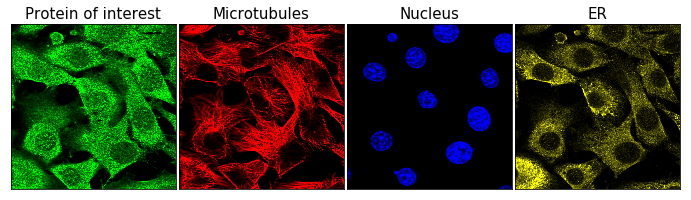

tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 1, 0, 0]])


In [25]:
img_index = 0
viz.viz_channels_separate(test_image, img_index)
print(test_label)

In [26]:
true_label[-2]

'2 21 25'

In [89]:
device = 'cuda'
im = test_image.to(device)
if not im.requires_grad:
    im.requires_grad_(True)
if im.grad is not None:
    im.grad.data.zero_()   
# pred, _ = forward_pass(im, net)    
pred = net.forward(im).norm()
# probs = F.sigmoid(pred).norm()
ind = 2
# probs = probs[:,ind]

# v = torch.zeros_like(probs)
# v[:,ind] = 1.

pred.backward()

In [90]:
grad_map = im.grad.data.clone().detach().cpu()

In [91]:
# plt.hist(grad_map.flatten(), bins=100)
np.unique(grad_map.flatten(), return_counts=True)
# print(np.min(grad_map.flatten()))

(array([-1.1569397 , -0.862655  , -0.64246863, ...,  1.4366026 ,
         1.6562555 ,  1.7031693 ], dtype=float32),
 array([1, 1, 1, ..., 1, 1, 1]))

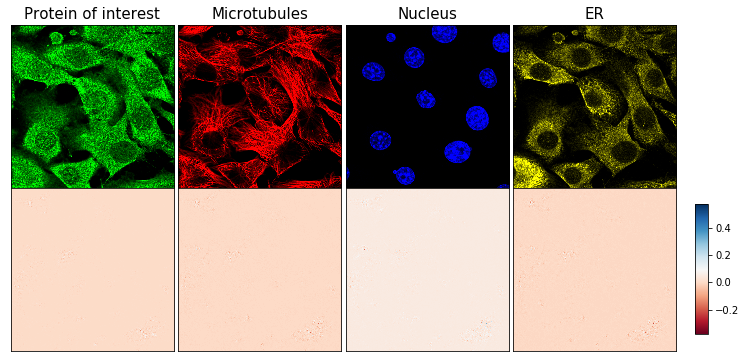

In [92]:
img_index = 0
viz.viz_channels_separate(test_image, img_index, grad_map, None)

In [78]:
grad_map[0][0].flatten().min()

tensor(-0.0007)

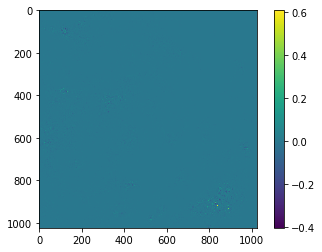

In [96]:
# plt.imshow(np.log(grad_map[0][0]-grad_map[0][0].flatten().min()), cmap="viridis")
plt.imshow(grad_map[0][0], cmap="viridis")
plt.colorbar()

In [81]:
np.log(grad_map[0][0]+grad_map[0][0].flatten().min())

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])

In [82]:
grad_map[0][0]

tensor([[ 4.5893e-07,  2.9898e-07, -1.8307e-07,  ...,  7.8606e-07,
          3.8878e-07,  9.7848e-08],
        [ 8.0504e-07,  2.0034e-06,  1.0235e-06,  ...,  7.1773e-07,
          3.3587e-07,  4.7891e-08],
        [ 7.3259e-07,  8.8571e-07,  2.0112e-07,  ...,  1.8116e-07,
         -1.7620e-07, -1.9469e-07],
        ...,
        [ 3.3886e-07,  5.9923e-07, -4.1731e-07,  ...,  7.7260e-07,
          2.2428e-07,  1.7295e-07],
        [-2.9535e-08,  4.7354e-07,  1.2631e-07,  ...,  4.2979e-07,
          1.2017e-07,  1.2068e-07],
        [-2.2544e-07,  5.5064e-08,  1.4270e-07,  ...,  1.3074e-07,
          1.4016e-07,  2.9472e-07]])

In [49]:
vmin = torch.min(torch.min(torch.min(grad_map[img_index,:,:,:], 1)[0], 1)[0]).item()
vmax = torch.max(torch.max(torch.max(grad_map[img_index,:,:,:], 1)[0], 1)[0]).item()
print(vmin, vmax)

-0.10452199727296829 0.11405997723340988


In [ ]:
grad_map